In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('../data/organized_uber.csv', parse_dates=['record_time'])
df.set_index('record_time', inplace=True)
df.index = df.index - pd.Timedelta(hours=7)
df['hour'] = df.index.hour
df['dayofmonth'] = df.index.day
df['date'] = df.index.date
df['dayofweek'] = df.index.dayofweek
df['weekofyear'] = df.index.weekofyear
df['display_name'].replace(['UberBLACK','UberSUV','UberSELECT','uberT','Yellow WAV','ASSIST','PEDAL','For Hire','#UberTAHOE','uberCAB','WarmUpChi'],
                           ['uberBLACK','uberSUV','uberSELECT','uberTAXI','uberWAV','uberASSIST','uberPEDAL','uberTAXI','uberTAHOE','uberTAXI','uberWARMUP'], inplace=True)
df = df.groupby(['date','hour','city','display_name']).mean().reset_index()
df['record_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")
df.set_index('record_time', inplace=True)

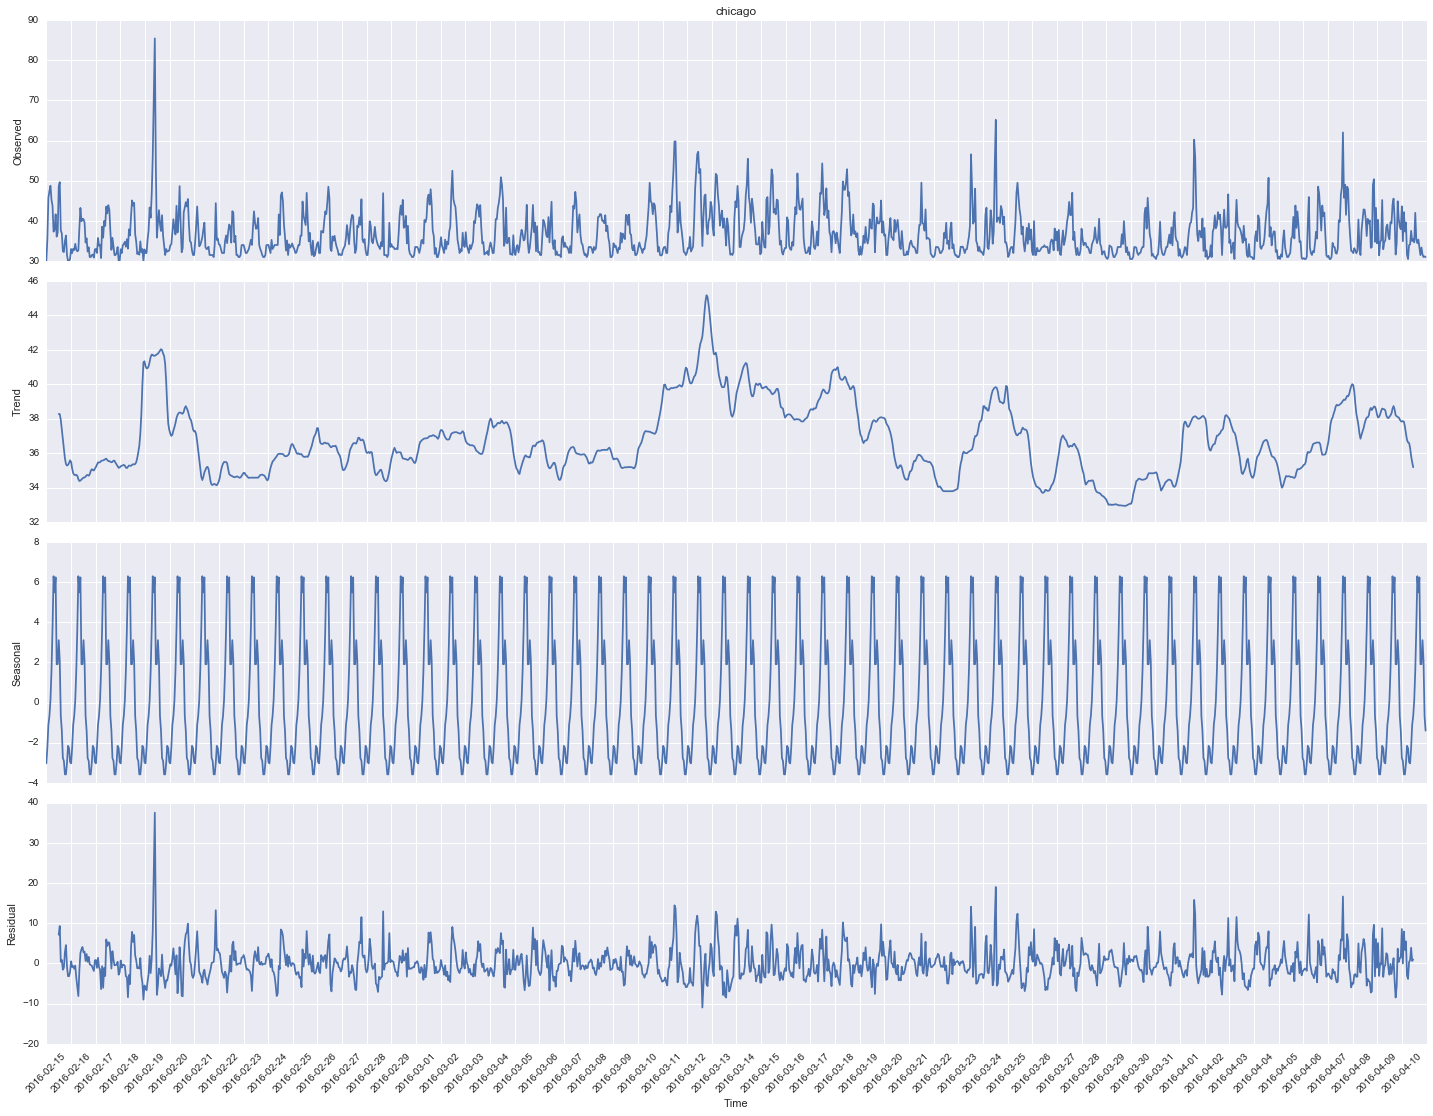

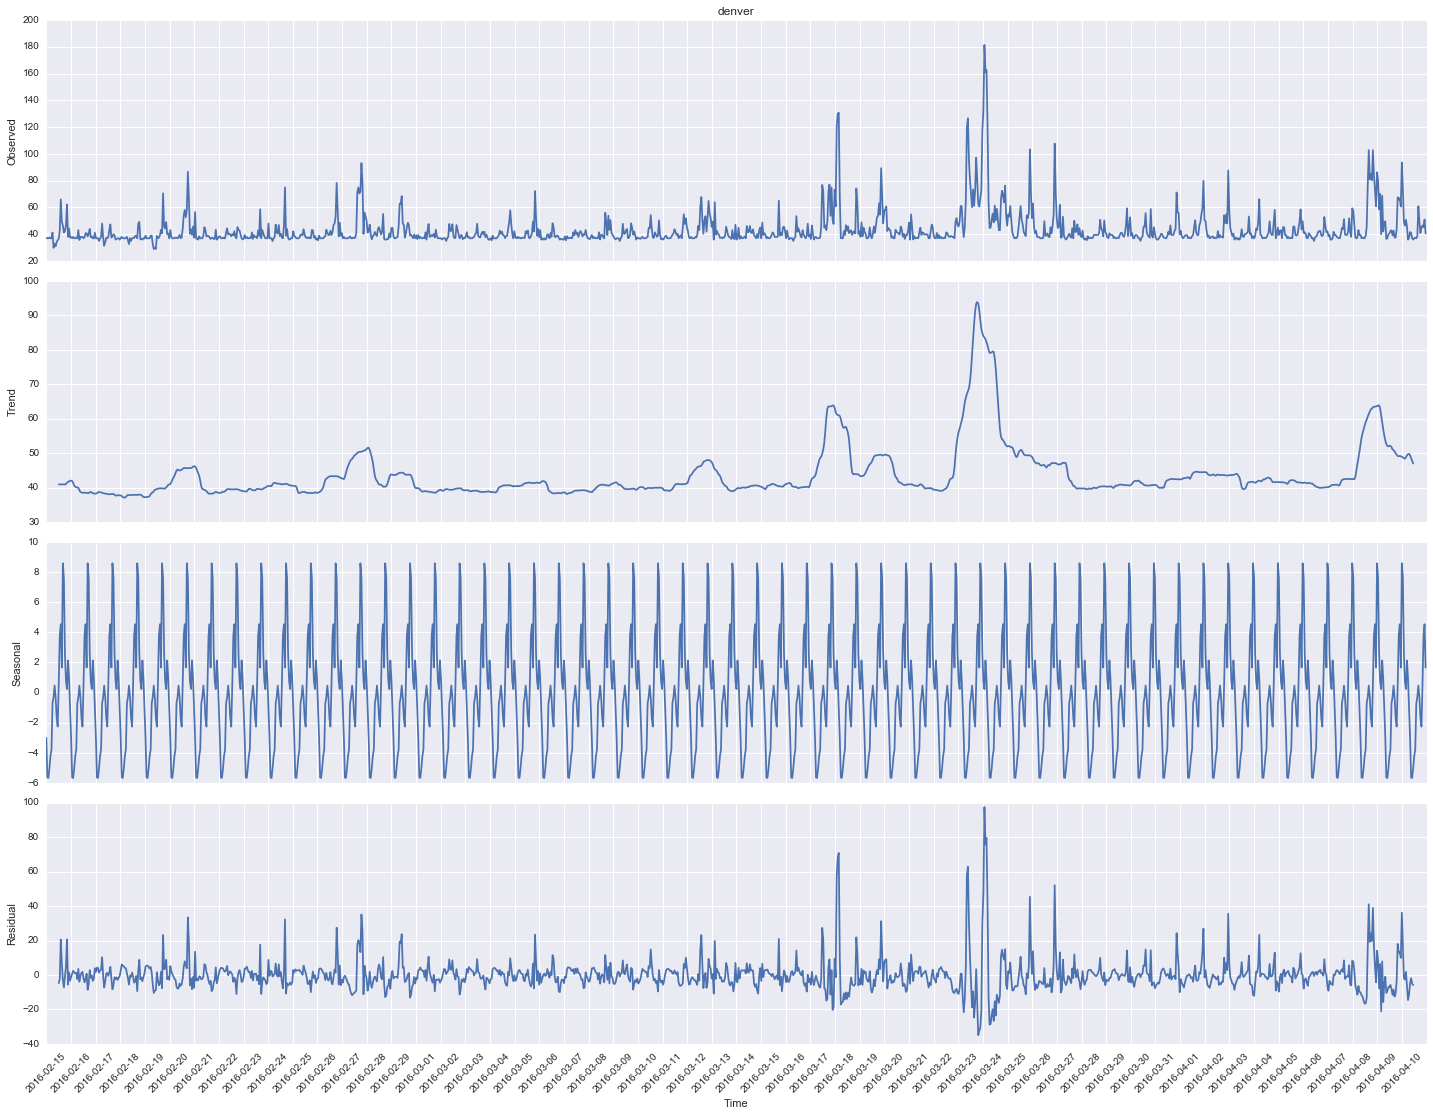

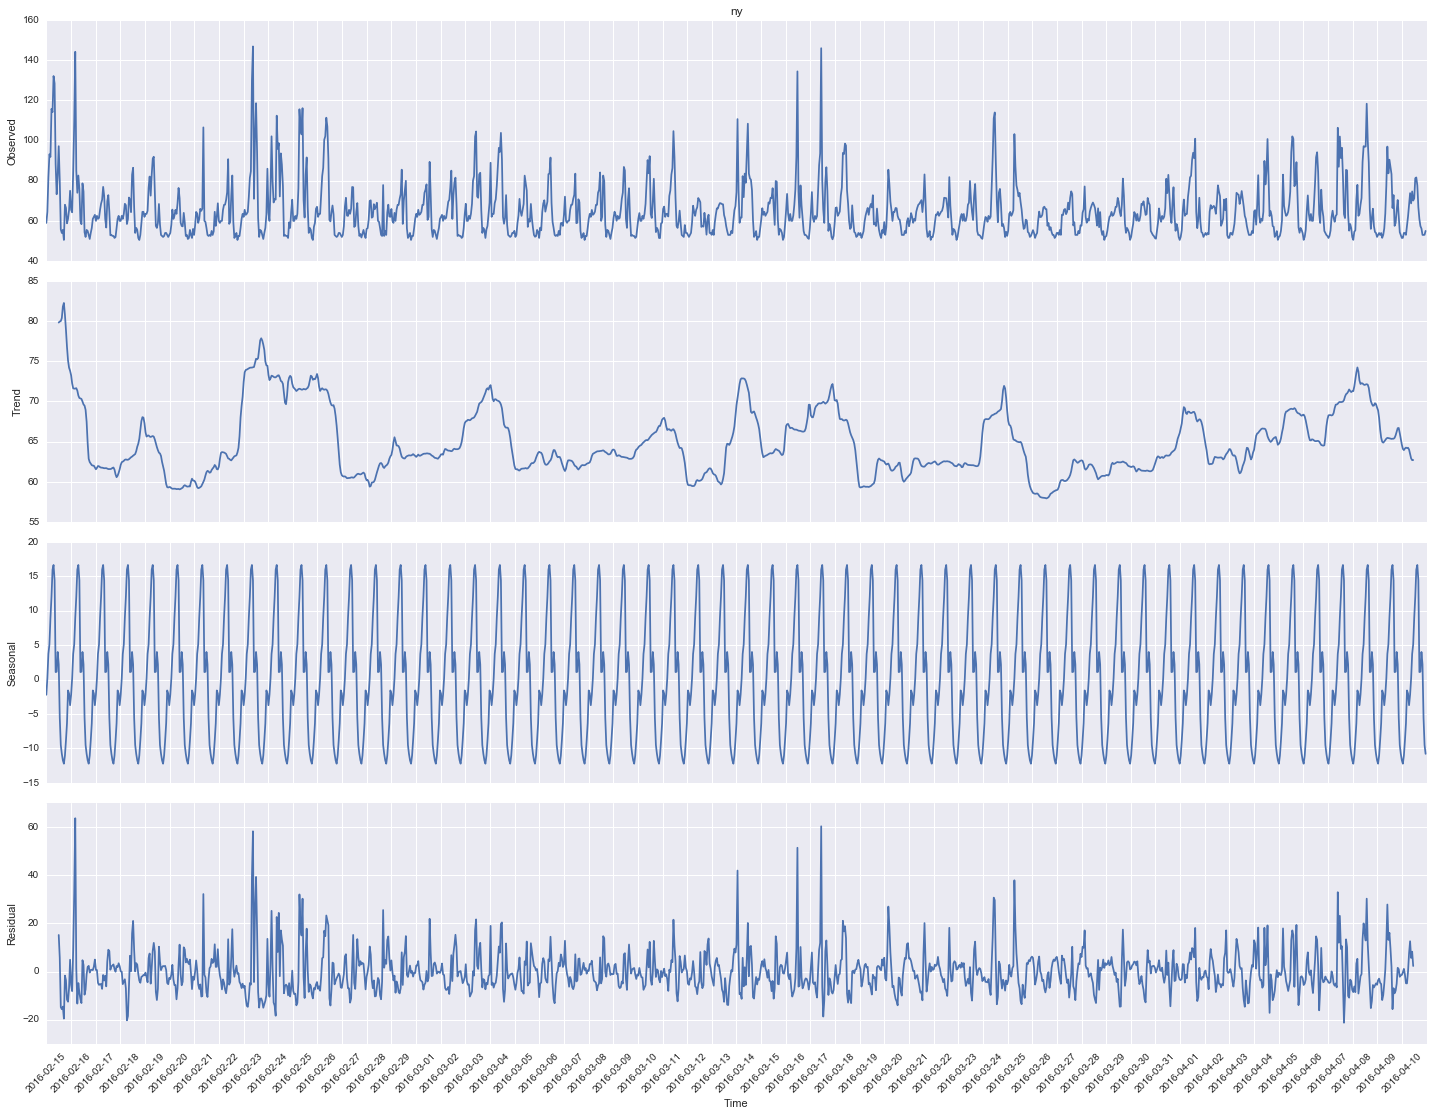

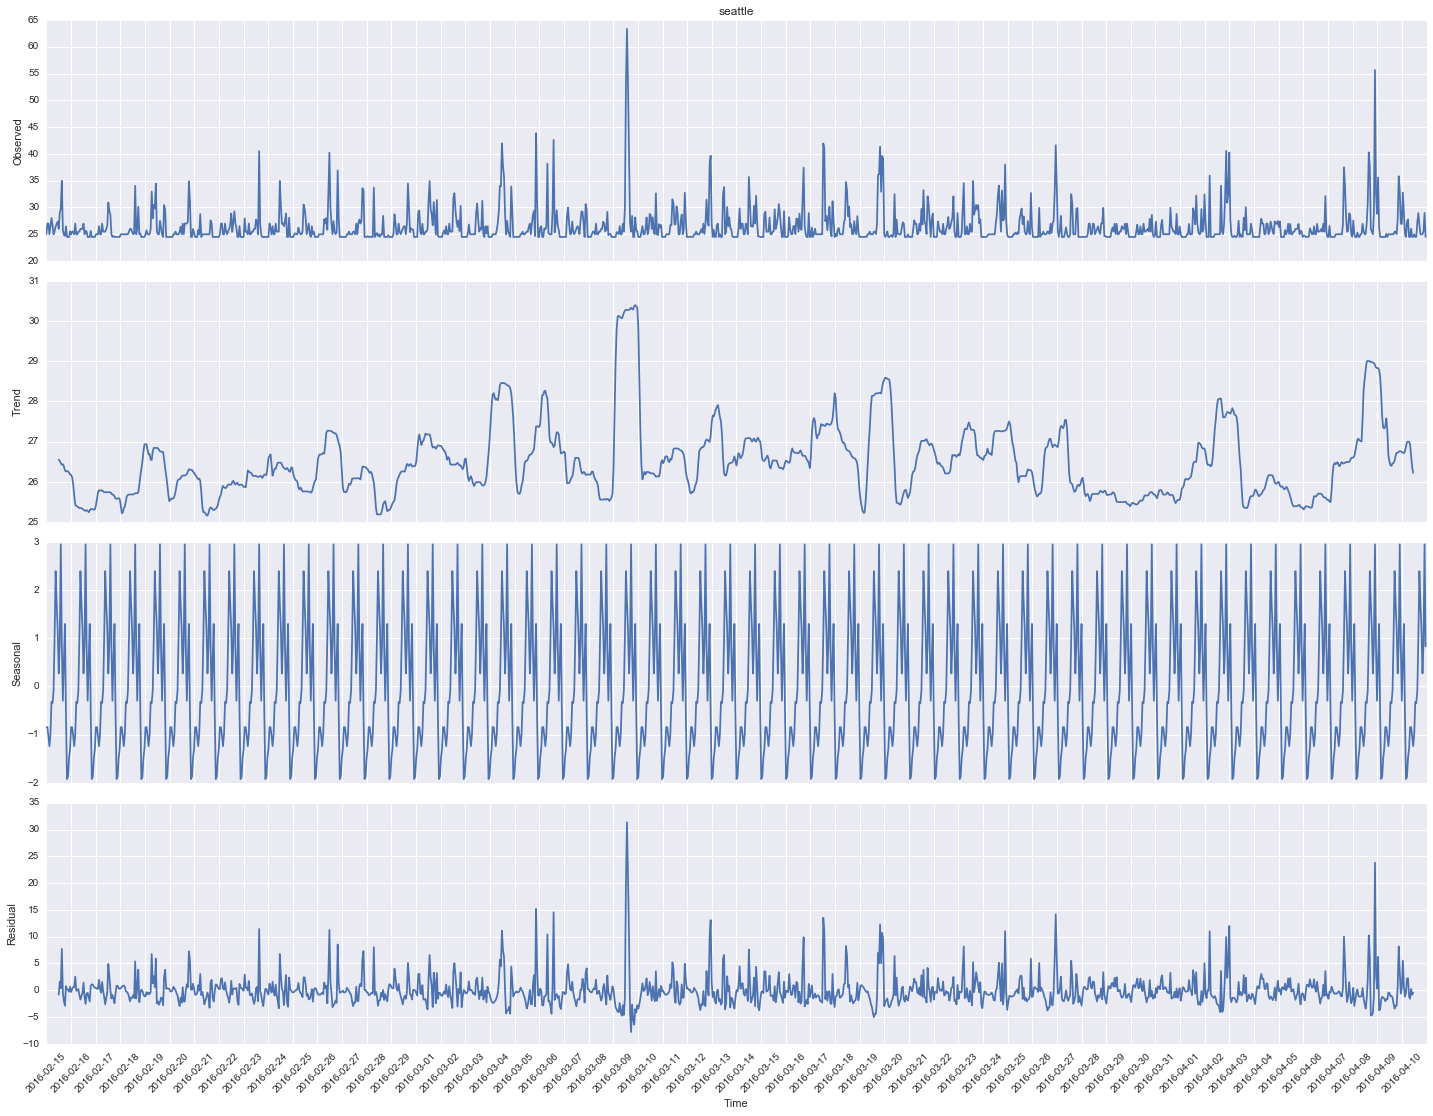

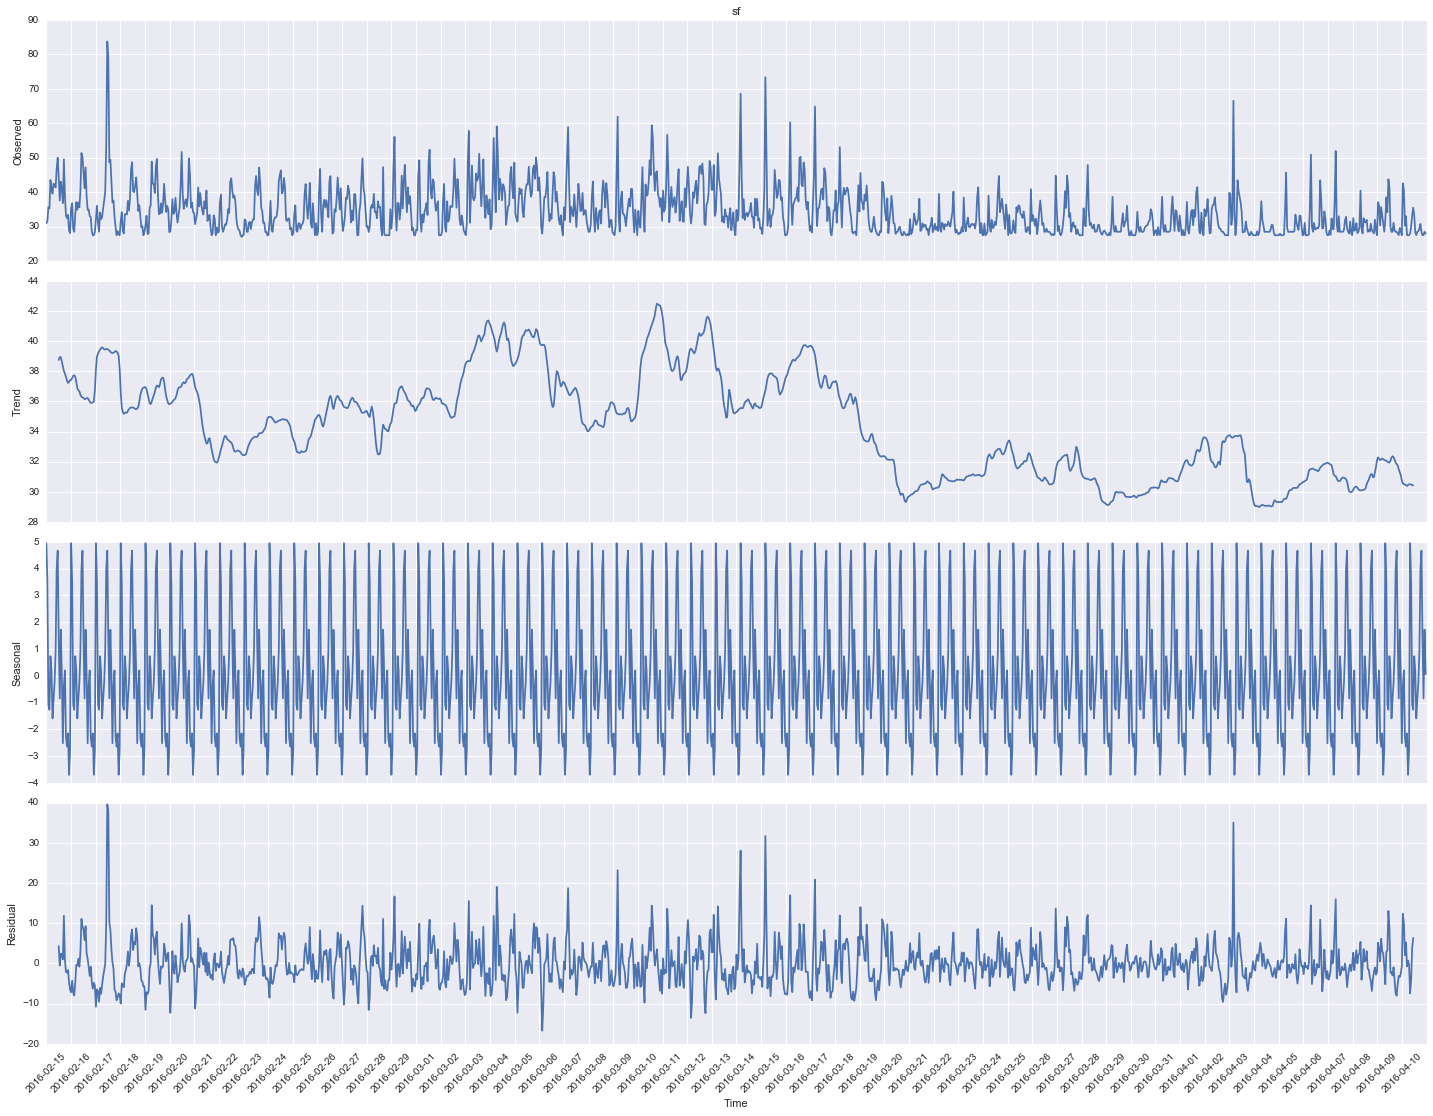

In [4]:
import statsmodels.api as sm

cities = df['city'].unique().tolist()
d = df.query("display_name == 'uberX' and city == 'denver'")['avg_price_est']
d_dates = np.unique(d.index.date)
for city in cities:
    h = df.query("display_name == 'uberX' and city == @city")
    decomposition = sm.tsa.seasonal_decompose(h['avg_price_est'].values, model='additive', freq=24)  
    fig = decomposition.plot()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    fig.tight_layout()
    axs_f = fig.get_axes()[0]
    axs_l = fig.get_axes()[-1]
    start, end = axs_l.get_xlim()
    stepsize=end/d_dates.shape[0]
    axs_l.xaxis.set_ticks(np.arange(start, end, stepsize))
    axs_l.set_xticklabels(d_dates, rotation='45')
    axs_f.set_title(city);
    axs_t = fig.get_axes()[1];
    for date in ['2016-02-22','2016-02-29','2016-03-07','2016-03-14','2016-03-21','2016-03-28']:
        axs_t.axvline(pd.to_datetime(date), color='r', linestyle='--');

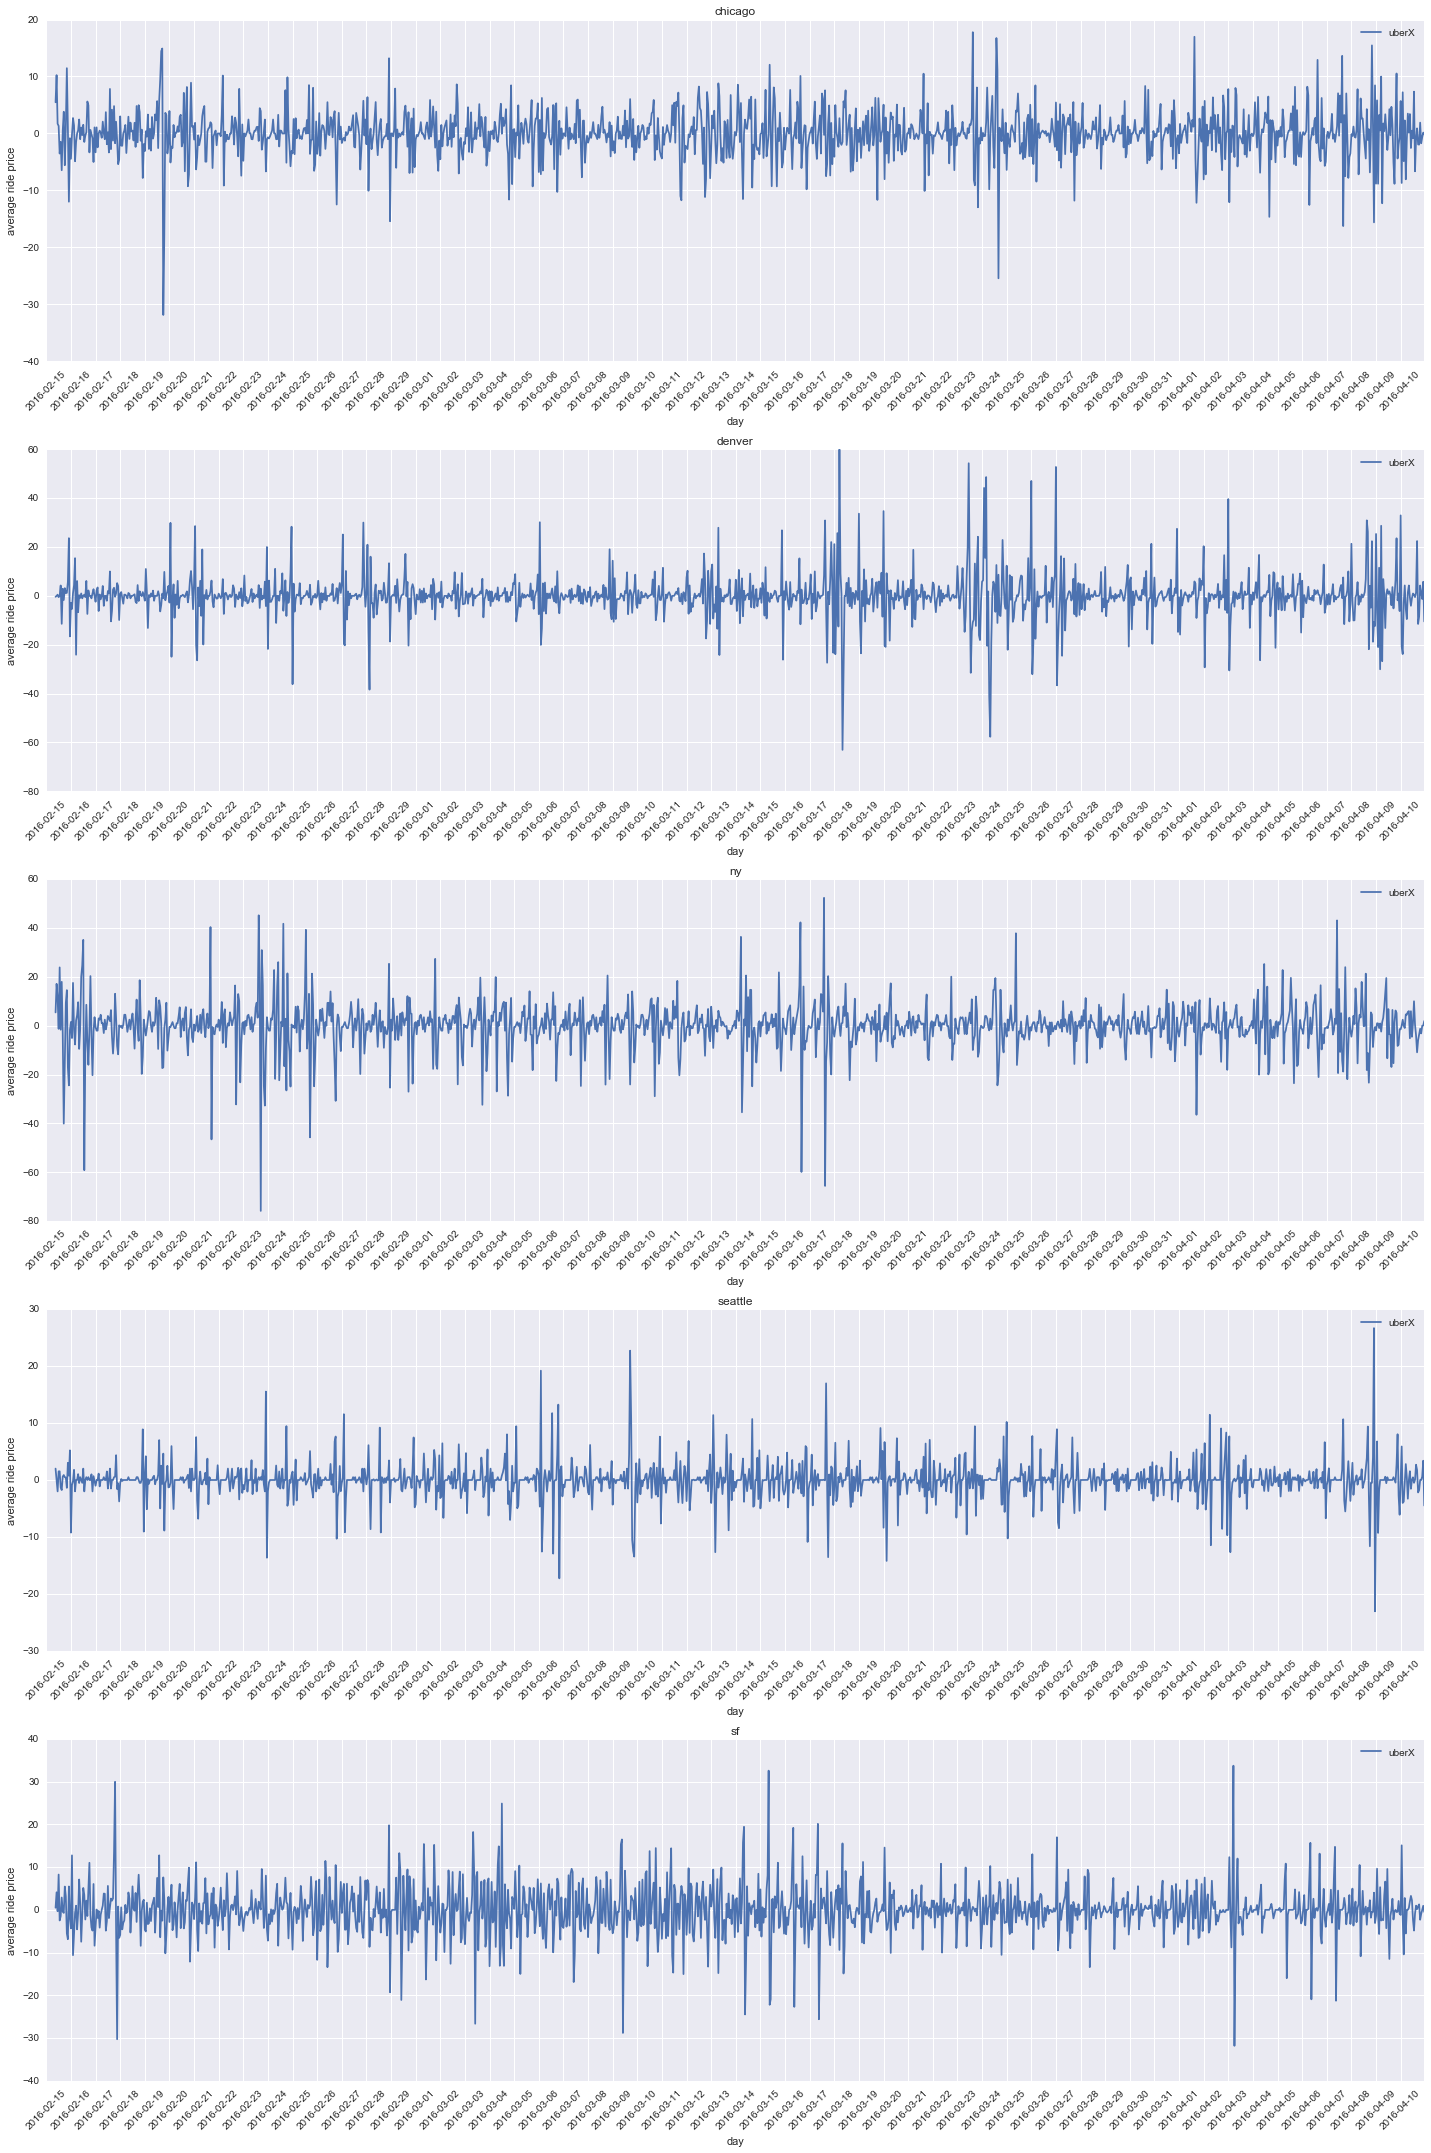

In [33]:
cities = df['city'].unique().tolist()
fig, ax = plt.subplots(5,1, figsize=(20,30))
d = df.query("display_name == 'uberX' and city == 'denver'")['avg_price_est']
dates = np.unique(d.index.date)
for i, axs in enumerate(ax.reshape(5,)):
    data = df.query("display_name == 'uberX' and city == @cities[@i]")['avg_price_est']
    mean_price = data.mean()
    axs.plot(data.diff(periods=1), label='uberX')
    axs.set_title(cities[i])
    axs.set_ylabel('average ride price')
    axs.set_xlabel('day')
    axs.set_xticks(dates)
    axs.set_xticklabels(dates, rotation='45')
    axs.legend(loc='upper right')
plt.tight_layout()

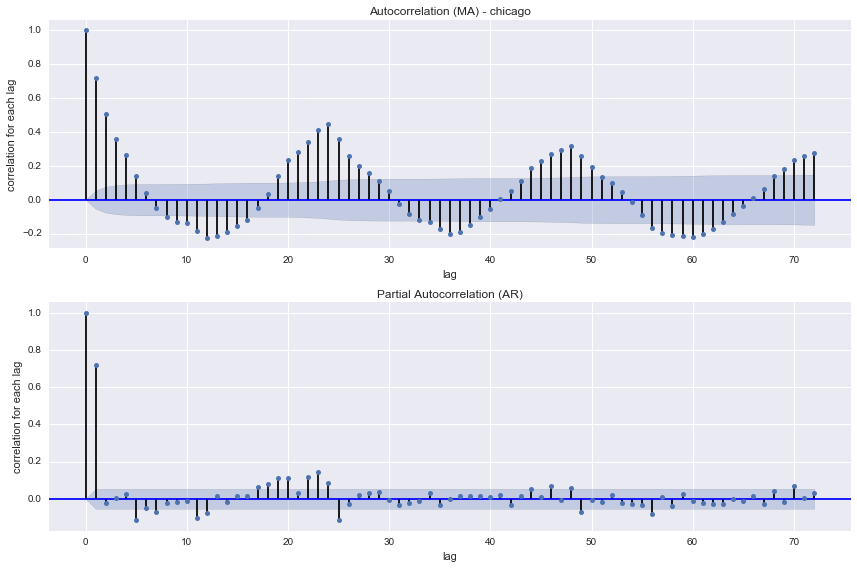

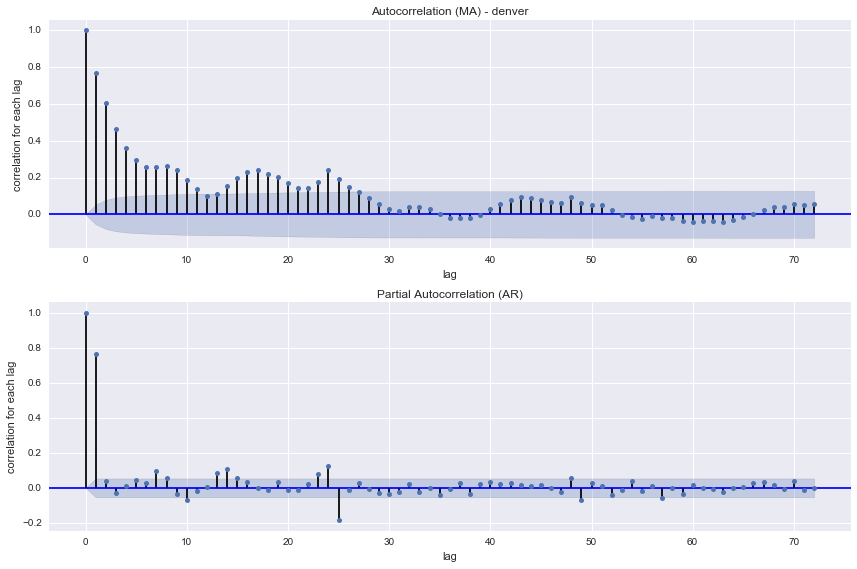

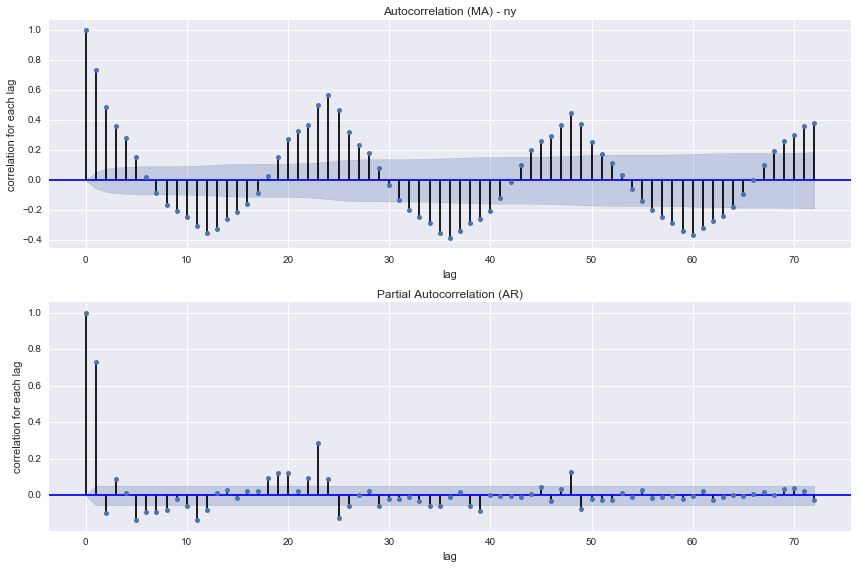

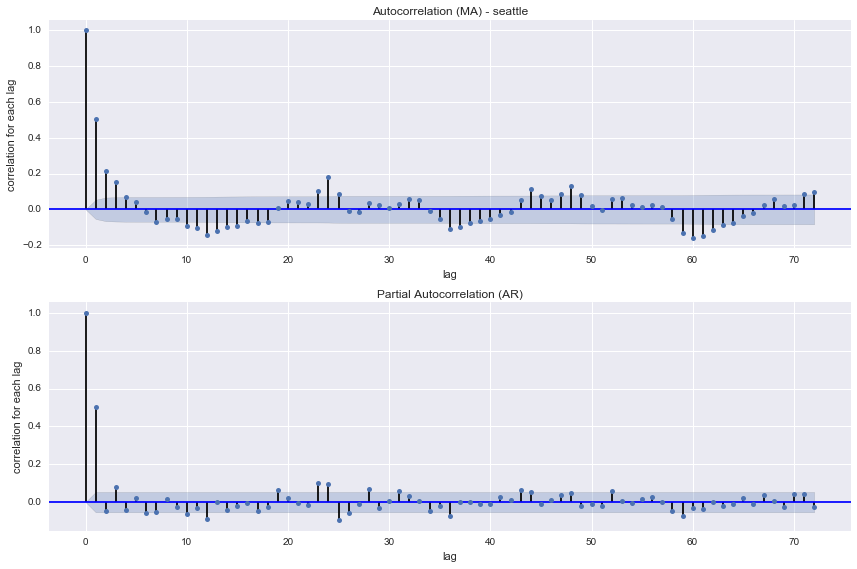

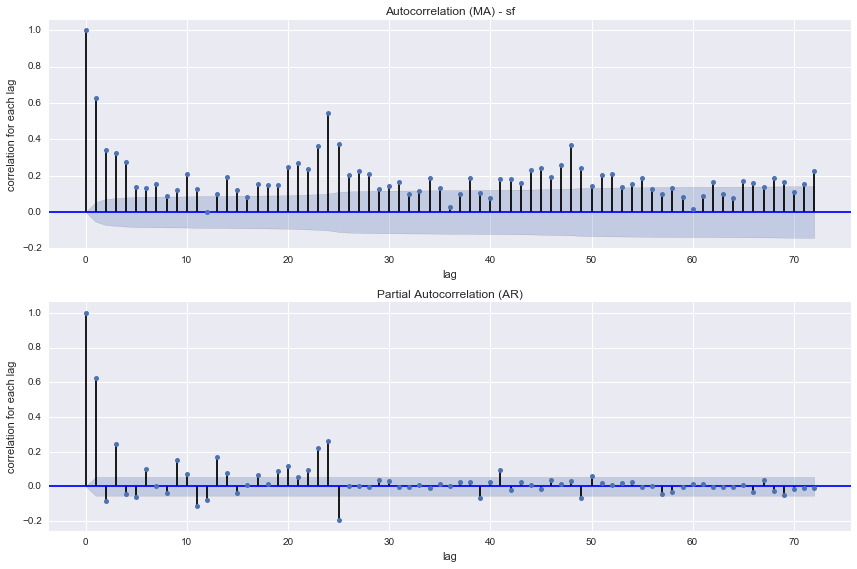

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(data, lags, label=''):
    """
    Input: Amount of lag
    Output: Plot of ACF/PACF
    """
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=lags, ax=ax1)
    ax1.set_ylabel('correlation for each lag')
    ax1.set_xlabel('lag')
    ax1.set_title('Autocorrelation (MA) - {}'.format(label))
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=lags, ax=ax2)
    ax2.set_xlabel('lag')
    ax2.set_ylabel('correlation for each lag')
    ax2.set_title('Partial Autocorrelation (AR)')
    plt.tight_layout()
cities = df['city'].unique().tolist()
for city in cities:
    h = df.query("display_name == 'uberX' and city == @city")['avg_price_est']
    plot_acf_pacf(h, lags=72, label=city)

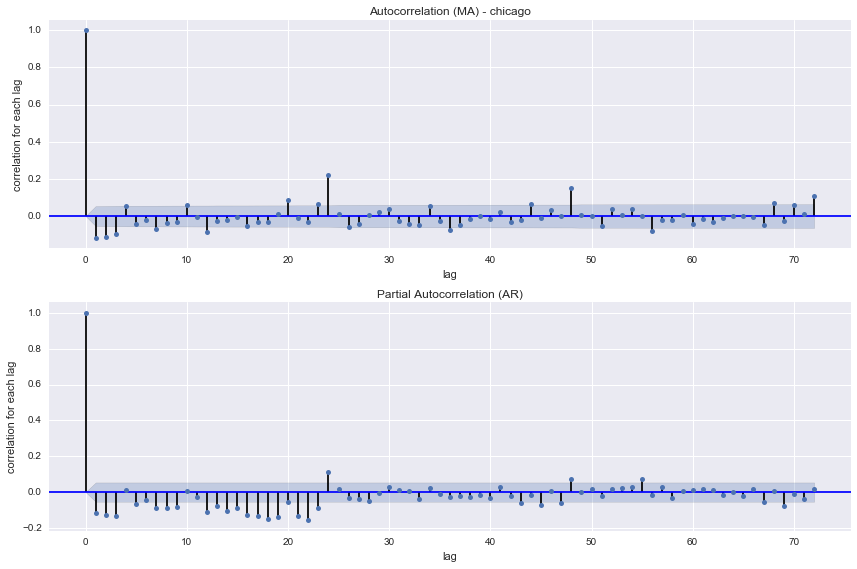

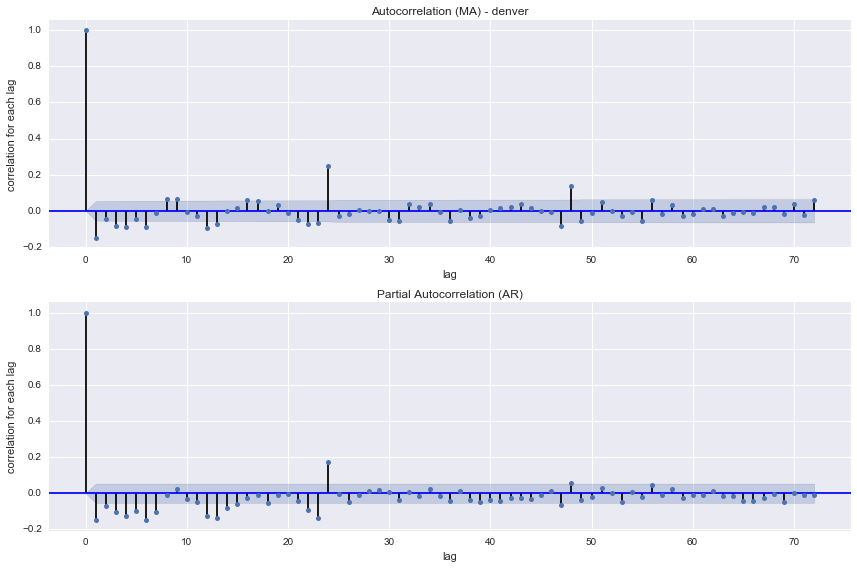

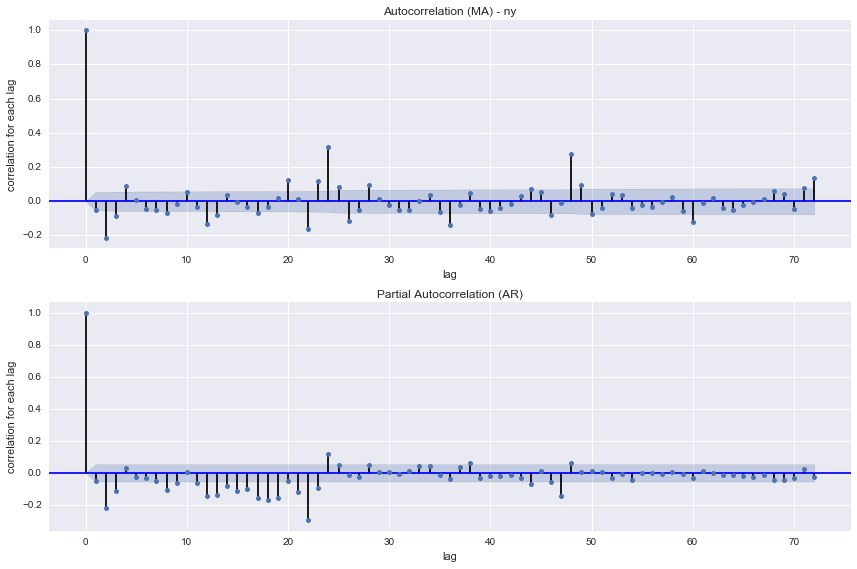

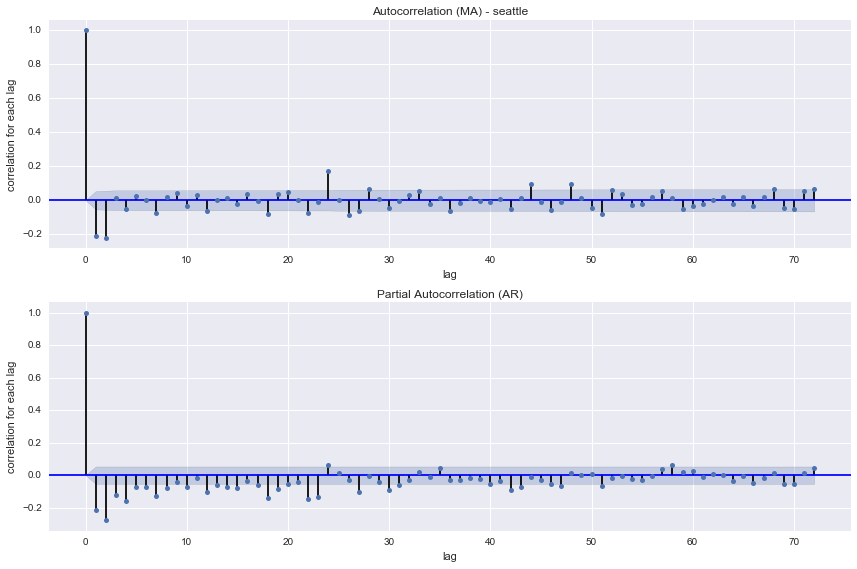

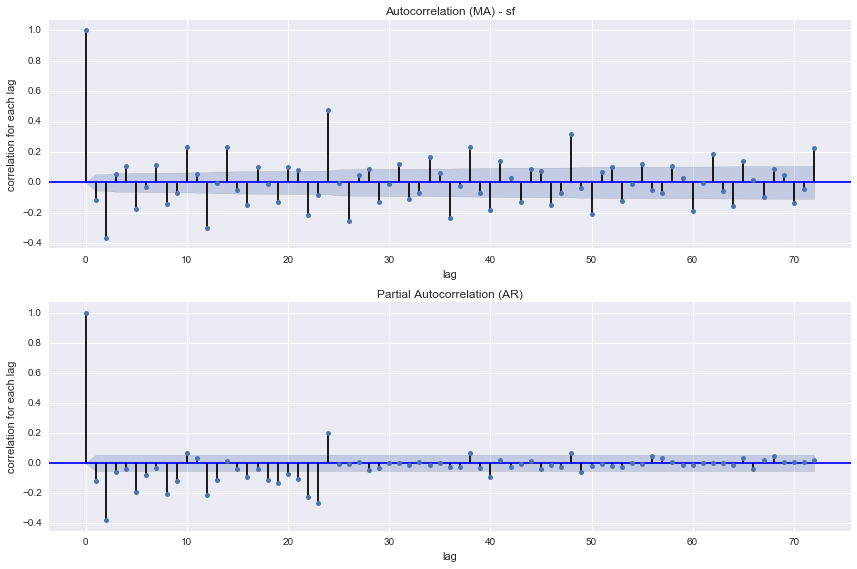

In [60]:
for city in cities:
    h = df.query("display_name == 'uberX' and city == @city")['avg_price_est']
    plot_acf_pacf(h.diff(periods=1)[1:], lags=72, label=city)

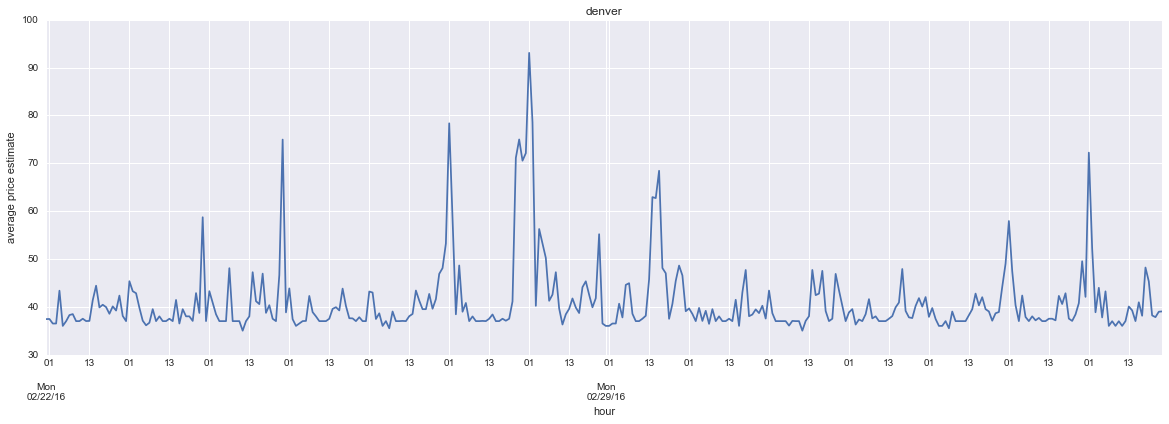

In [48]:
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter, HourLocator

s = df.query("display_name == 'uberX' and city == 'denver' and weekofyear >= 8 and weekofyear <= 9")
fig, ax = plt.subplots(figsize=(20,6))
ax.plot_date(s.index.to_pydatetime(), s['avg_price_est'].values, '-');

ax.xaxis.set_minor_locator(HourLocator(byhour=range(24), interval=12))
ax.xaxis.set_minor_formatter(DateFormatter('%H'))
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=7))
ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
ax.xaxis.grid(True, which="minor")
ax.set_xlabel('hour')
ax.set_ylabel('average price estimate');
ax.set_title('denver');

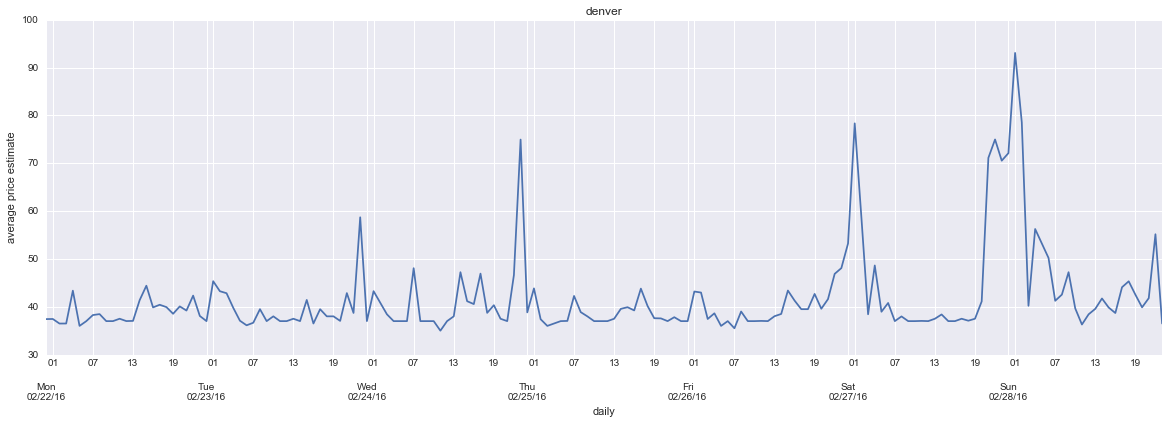

In [9]:
s = df.query("display_name == 'uberX' and city == 'denver' and weekofyear >= 8 and weekofyear <= 8")
fig, ax = plt.subplots(figsize=(20,6))
ax.plot_date(s.index.to_pydatetime(), s['avg_price_est'].values, '-');

ax.xaxis.set_minor_locator(HourLocator(byhour=range(24), interval=6))
ax.xaxis.set_minor_formatter(DateFormatter('%H'))
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=1))
ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
ax.xaxis.grid(True, which="minor")
ax.set_xlabel('daily')
ax.set_ylabel('average price estimate');
ax.set_title('denver');

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

features = ['avg_price_est','city','display_name','trip_duration','trip_distance','weekofyear','pickup_estimate','surge_multiplier']
sample = pd.get_dummies(df[features], columns=['city','display_name']).drop(['city_chicago','display_name_uberASSIST'], axis=1).dropna()

train_set = sample.query("weekofyear == 8")
test_set = sample.query("weekofyear == 9")

y = train_set['avg_price_est'].values
X = train_set[train_set.columns[1:]]

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 5020
Model:             SARIMAX(5, 0, 3)x(5, 0, 3, 24)   Log Likelihood              -17994.809
Date:                            Wed, 13 Apr 2016   AIC                          36065.619
Time:                                    18:13:56   BIC                          36313.424
Sample:                                02-22-2016   HQIC                         36152.453
                                     - 02-28-2016                                         
Covariance Type:                              opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
trip_duration                0.0087      0.000     34.182      0.000       0.008      

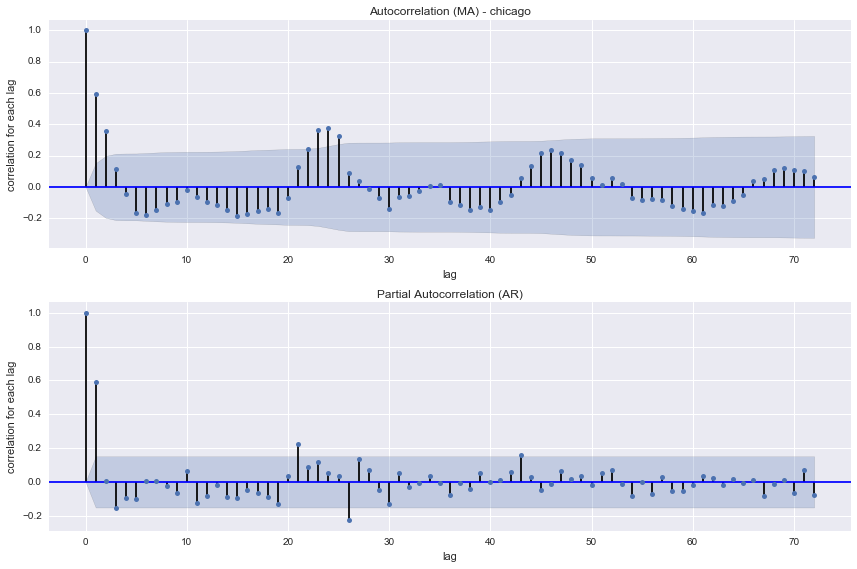

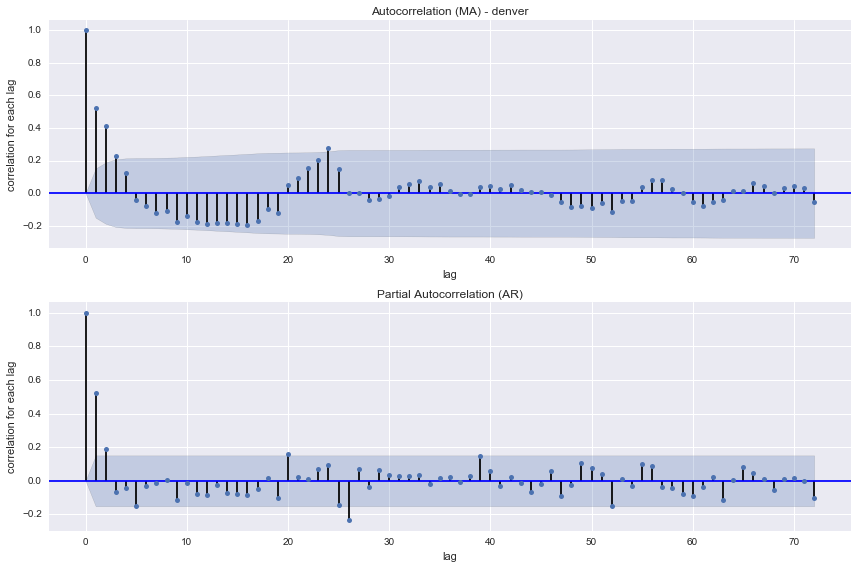

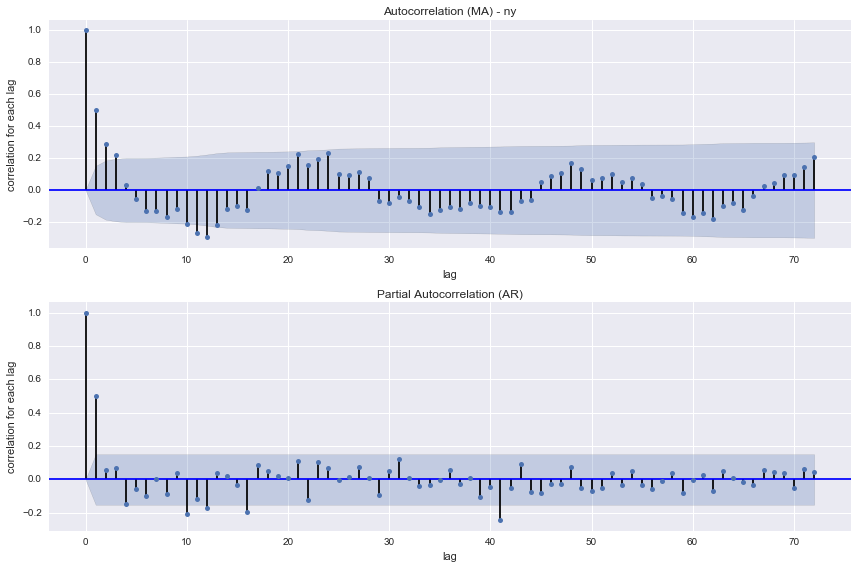

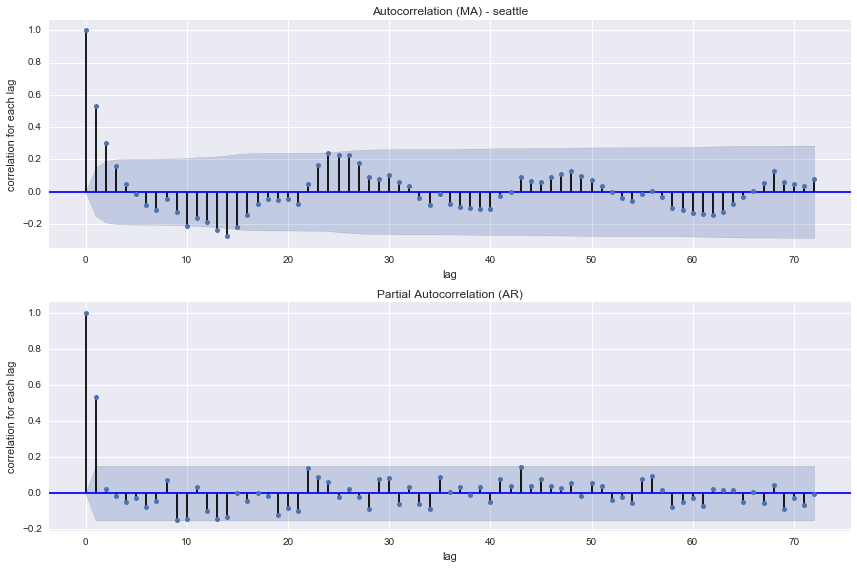

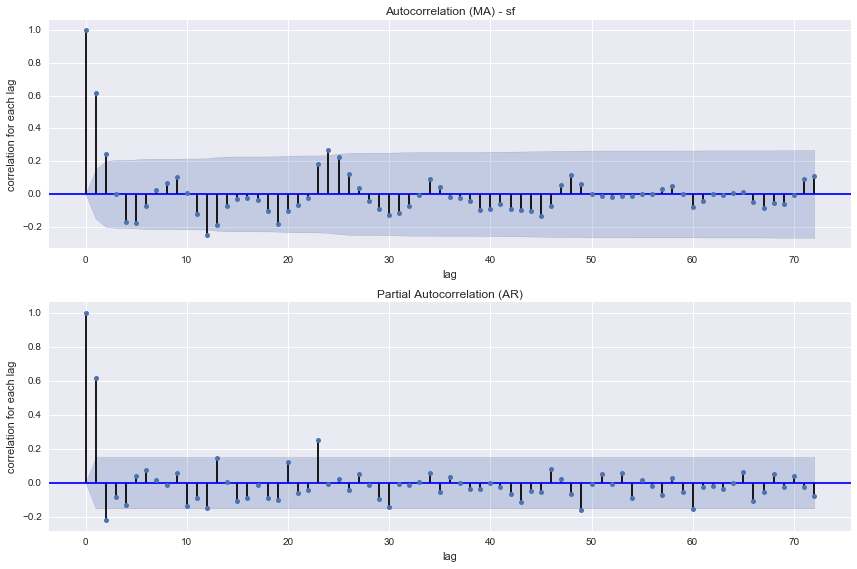

In [36]:
model = SARIMAX(endog=y, exog=X, order=(5,0,3), seasonal_order=(5,0,3,24)).fit()
print model.summary()
cities = df['city'].unique().tolist()
for city in cities:
    r = pd.concat([X, pd.DataFrame(model.resid, columns=['resid'])], axis=1)
    if city != "chicago":
        h = r.query("display_name_uberX == 1 and city_{} == 1".format(city))['resid']
    else:
        h = r.query("display_name_uberX == 1 and city_denver == 0 and city_sf == 0 and city_seattle == 0 and city_ny == 0")['resid']
    plot_acf_pacf(h, lags=72, label=city)

In [6]:
train_set.to_csv("../data/week8_train_uber.csv")
test_set.to_csv("../data/week9_test_uber.csv")

In [7]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
rforecast = rpackages.importr('forecast')

In [10]:
r = robjects.r("""
train_set = read.csv('data/week8_train_uber.csv')
test_set = read.csv('data/week9_test_uber.csv')
y = train_set['avg_price_est']
features = c(
 'trip_duration',
 'trip_distance',
 'pickup_estimate',
 'surge_multiplier',
 'city_denver',
 'city_ny',
 'city_seattle',
 'city_sf',
 'display_name_uberBLACK',
 'display_name_uberESPANOL',
 'display_name_uberFAMILY',
 'display_name_uberPEDAL',
 'display_name_uberSELECT',
 'display_name_uberSUV',
 'display_name_uberTAXI',
 'display_name_uberWARMUP',
 'display_name_uberWAV',
 'display_name_uberX',
 'display_name_uberXL')
X = train_set[features]
X_test = test_set[features]
fit = auto.arima(y, xreg=X)
y_pred = forecast(fit, xreg=X_test)
""")

In [11]:
print robjects.r("""y_pred['model']""")

$model
Series: y 
ARIMA(5,0,3) with non-zero mean 

Coefficients:
          ar1      ar2      ar3      ar4     ar5     ma1     ma2     ma3
      -0.4865  -0.6179  -0.6376  -0.4847  0.2326  0.0489  0.4651  0.5971
s.e.   0.0395   0.0375   0.0370   0.0290  0.0275  0.0390  0.0272  0.0201
      intercept  trip_duration  trip_distance  pickup_estimate
       -66.3978         0.0085         2.1899          -0.0049
s.e.     3.8212         0.0002         0.1896           0.0013
      surge_multiplier  city_denver  city_ny  city_seattle  city_sf
               49.8752      -5.6583  15.3763        0.0748   3.2524
s.e.            0.6621       1.4192   0.5691        1.2504   1.0646
      display_name_uberBLACK  display_name_uberESPANOL  display_name_uberFAMILY
                     48.7258                  -10.5113                  21.1943
s.e.                  1.0050                    1.0683                   1.2869
      display_name_uberPEDAL  display_name_uberSELECT  display_name_uberSUV
      

In [18]:
print robjects.r("""names(y_pred)""")

 [1] "method"    "model"     "level"     "mean"      "lower"     "upper"    
 [7] "x"         "xname"     "fitted"    "residuals"



In [38]:
r_lower = robjects.r("""y_pred['lower']""")[0]
r_upper = robjects.r("""y_pred['upper']""")[0]
r_pred = robjects.r("""y_pred['mean']""")[0]

In [46]:
y_pred = [r_pred[i] for i in range(len(r_pred))]
y_pred = pd.DataFrame(y_pred, index=test_set.index, columns=['y_pred'])

In [61]:
testplot = pd.concat([test_set, y_pred], axis=1)
testplot[['avg_price_est','y_pred']]

avg_price_est      y_pred
record_time                                   
2016-02-29 00:00:00      87.000000   81.210312
2016-02-29 00:00:00      31.500000   27.504537
2016-02-29 00:00:00      61.784483   64.224644
2016-02-29 00:00:00     109.000000  100.535547
2016-02-29 00:00:00      31.500000   33.843495
2016-02-29 00:00:00      53.500000   54.276964
2016-02-29 00:00:00     106.000000   99.983113
2016-02-29 00:00:00      71.500000   77.673585
2016-02-29 00:00:00     130.000000  113.841519
2016-02-29 00:00:00      36.000000   48.208951
2016-02-29 00:00:00      67.500000   68.662974
2016-02-29 00:00:00     109.000000  106.151701
2016-02-29 00:00:00      65.000000   78.321383
2016-02-29 00:00:00     136.500000  120.149669
2016-02-29 00:00:00       0.000000   14.118522
2016-02-29 00:00:00      55.000000   54.422557
2016-02-29 00:00:00      83.000000   78.039788
2016-02-29 00:00:00      55.000000   67.836047
2016-02-29 00:00:00      46.500000   47.931381
2016-02-29 00:00:00      65.000000   79.204871
2016-02-29 00:00:00      32.500000   25.103708
2016-02-29 00:00:00      24.500000   17.211955
2016-02-29 00:00:00      45.500000   39.860314
2016-02-29 00:00:00      27.500000   24.634012
2016-02-29 00:00:00      68.500000   72.201486
2016-02-29 00:00:00      60.741379   52.514640
2016-02-29 00:00:00      84.500000   84.219685
2016-02-29 00:00:00      27.500000   23.839190
2016-02-29 00:00:00      42.000000   46.023026
2016-02-29 01:00:00      87.000000   84.446641
...                            ...         ...
2016-03-06 23:00:00      87.000000   85.102020
2016-03-06 23:00:00      31.500000   25.193195
2016-03-06 23:00:00      59.500000   64.733794
2016-03-06 23:00:00     109.000000   97.119157
2016-03-06 23:00:00      31.500000   35.736359
2016-03-06 23:00:00      57.631579   61.328956
2016-03-06 23:00:00     106.000000   98.734170
2016-03-06 23:00:00      71.500000   78.371143
2016-03-06 23:00:00     130.000000  110.886463
2016-03-06 23:00:00      39.026316   52.489895
2016-03-06 23:00:00      71.634615   72.573747
2016-03-06 23:00:00     104.500000  102.411881
2016-03-06 23:00:00      62.500000   74.376077
2016-03-06 23:00:00     130.500000  114.662941
2016-03-06 23:00:00       0.000000   10.991016
2016-03-06 23:00:00      52.500000   52.713530
2016-03-06 23:00:00      79.500000   74.659716
2016-03-06 23:00:00      55.000000   67.346774
2016-03-06 23:00:00      33.750000   24.447622
2016-03-06 23:00:00      46.500000   46.547092
2016-03-06 23:00:00      65.000000   79.566645
2016-03-06 23:00:00      32.500000   26.388661
2016-03-06 23:00:00      26.605263   21.949794
2016-03-06 23:00:00      45.500000   38.685892
2016-03-06 23:00:00      38.781250   47.604051
2016-03-06 23:00:00      68.500000   73.690549
2016-03-06 23:00:00      59.000000   52.766108
2016-03-06 23:00:00      84.500000   85.900022
2016-03-06 23:00:00      36.307018   42.841155
2016-03-06 23:00:00      43.157895   46.423516

[5004 rows x 2 columns]

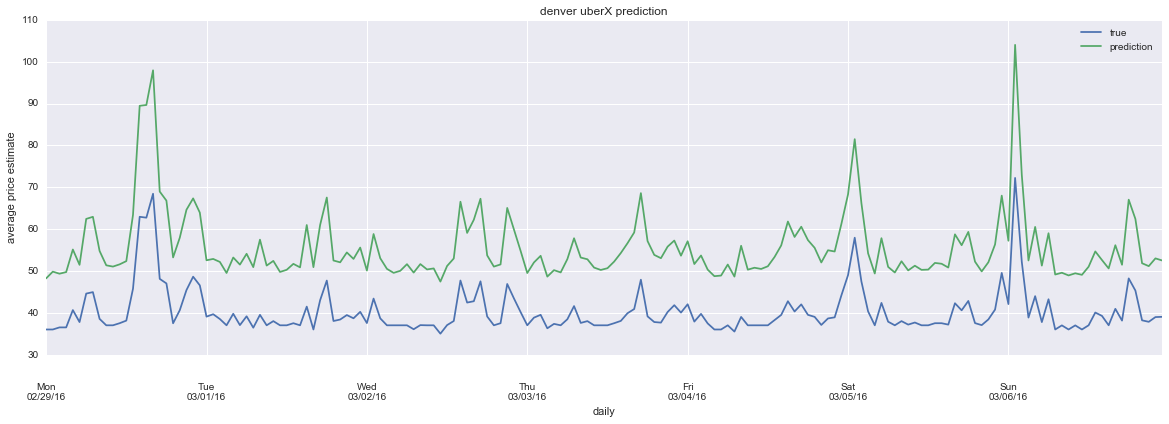

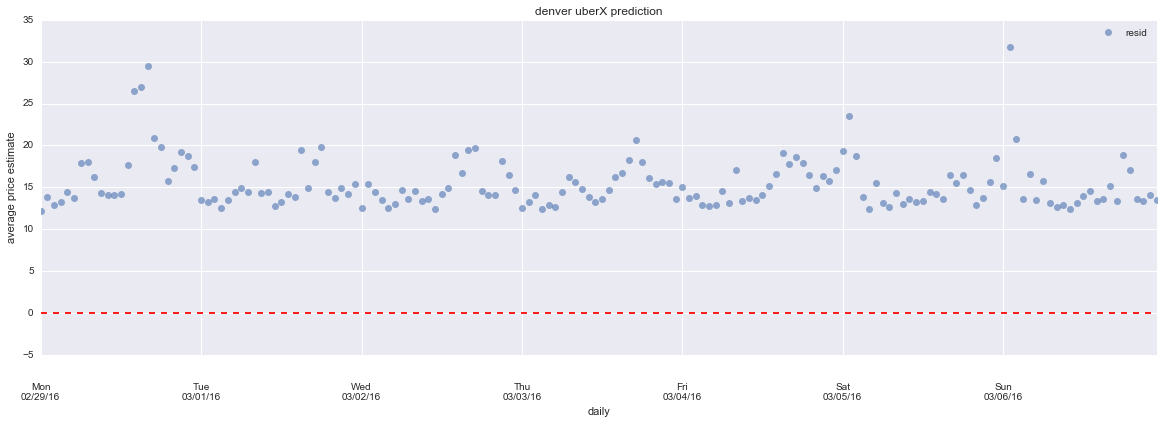

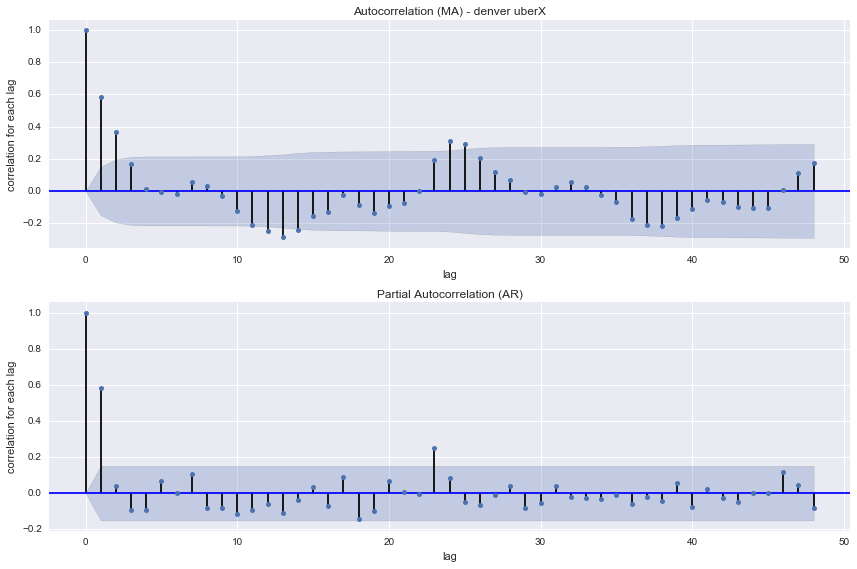

In [66]:
testplot['resid'] = testplot['y_pred'] - testplot['avg_price_est'] 
testsample = testplot.query("display_name_uberX == 1 and city_denver == 1")

fig, ax = plt.subplots(figsize=(20,6))
ax.plot_date(testsample.index.to_pydatetime(), testsample['avg_price_est'].values, '-', label='true');
ax.plot_date(testsample.index.to_pydatetime(), testsample['y_pred'].values, '-', label='prediction');
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=1))
ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
ax.xaxis.grid(True, which="minor")
ax.set_xlabel('daily')
ax.set_ylabel('average price estimate');
ax.set_title('denver uberX prediction');
ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(20,6))
ax.plot_date(testsample.index.to_pydatetime(), testsample['resid'].values, 'o', label='resid', alpha=0.6);
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=1))
ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
ax.xaxis.grid(True, which="minor")
ax.axhline(0, color='r', ls='--')
ax.set_xlabel('daily')
ax.set_ylabel('average price estimate');
ax.set_title('denver uberX prediction');
ax.legend(loc='upper right');

plot_acf_pacf(testsample['resid'], lags=48, label='denver uberX')

In [67]:
from sklearn.metrics import mean_squared_error
print 'MSE of test prediction wk8 to wk9:', mean_squared_error(testplot['avg_price_est'], testplot['y_pred'])

MSE of test prediction wk8 to wk9: 110.825704294


LinearRegression MSE: 63.2854293941
Ridge MSE: 63.2609253275
Lasso MSE: 212.857669775
ElasticNet MSE: 541.624844942


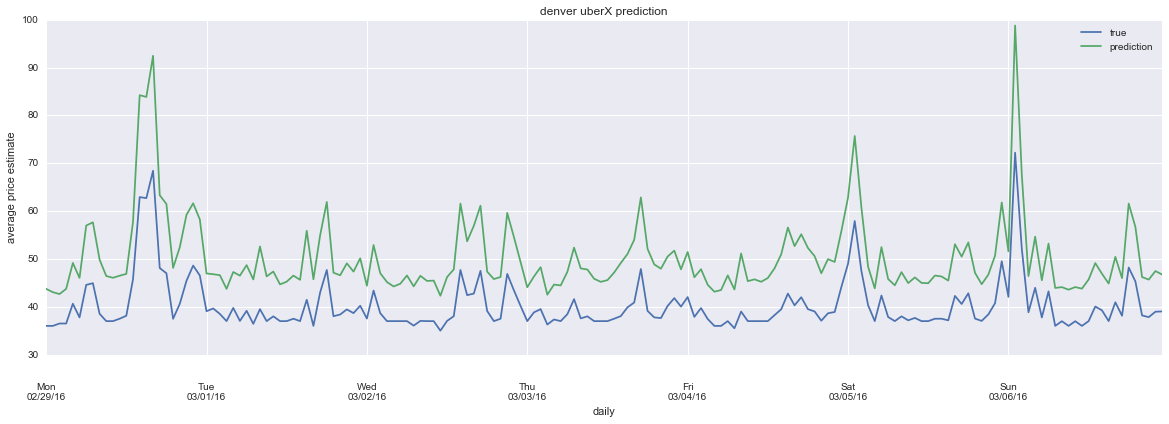

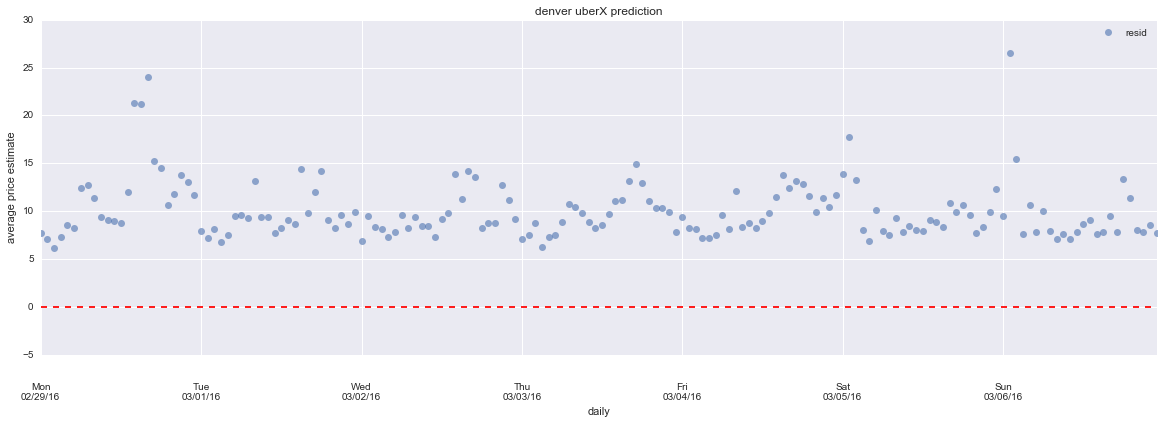

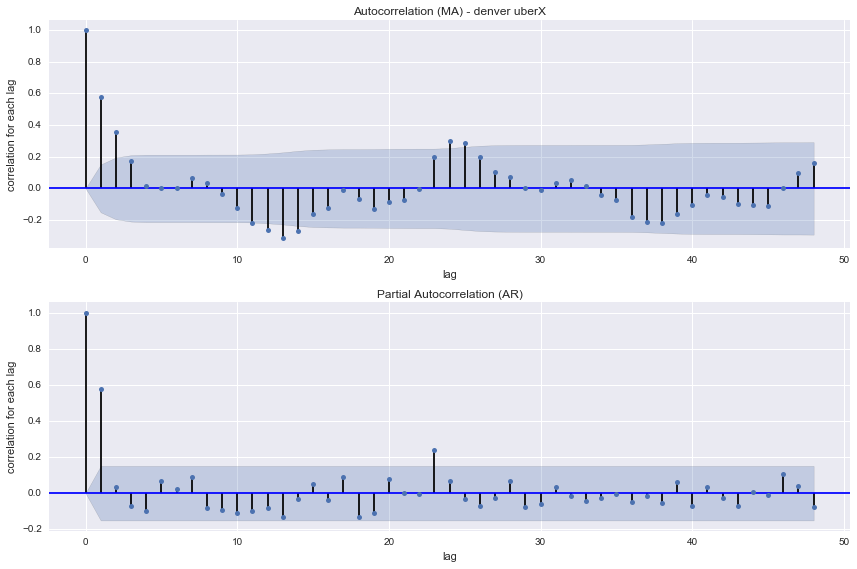

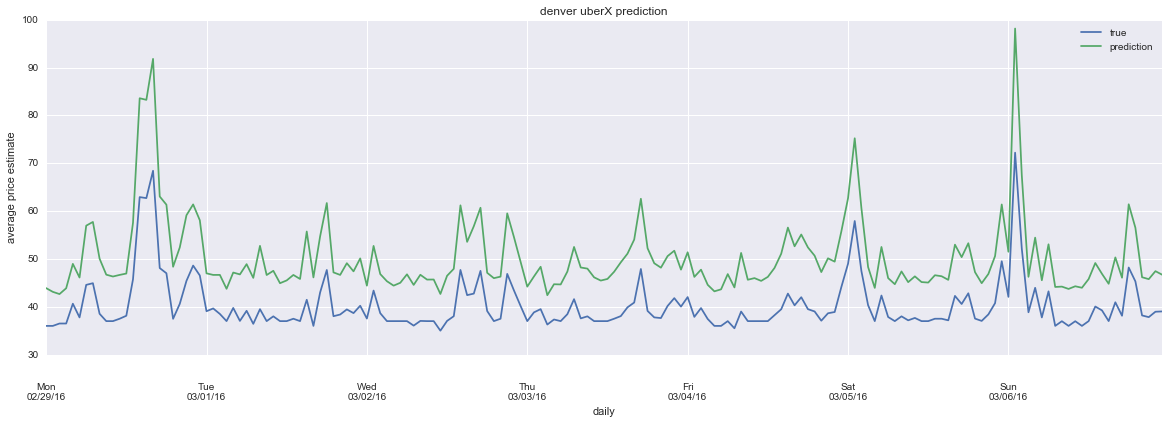

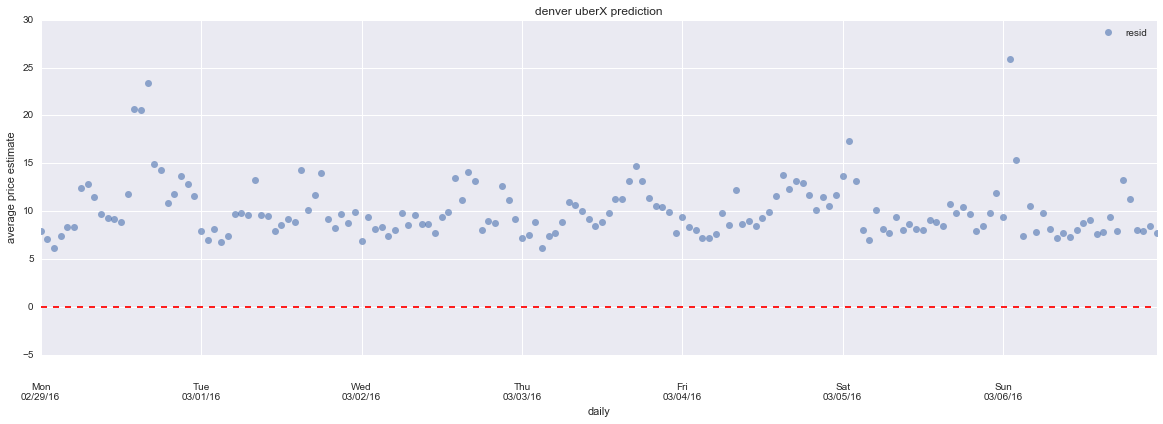

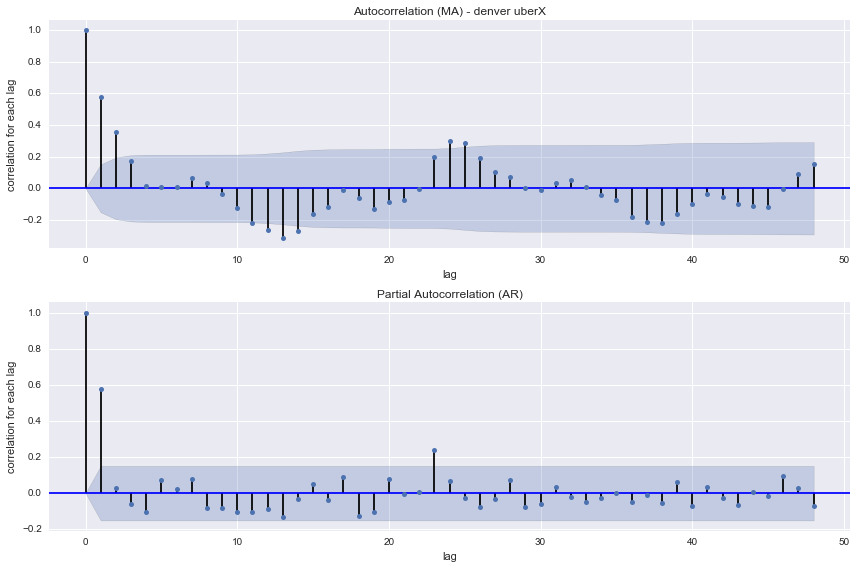

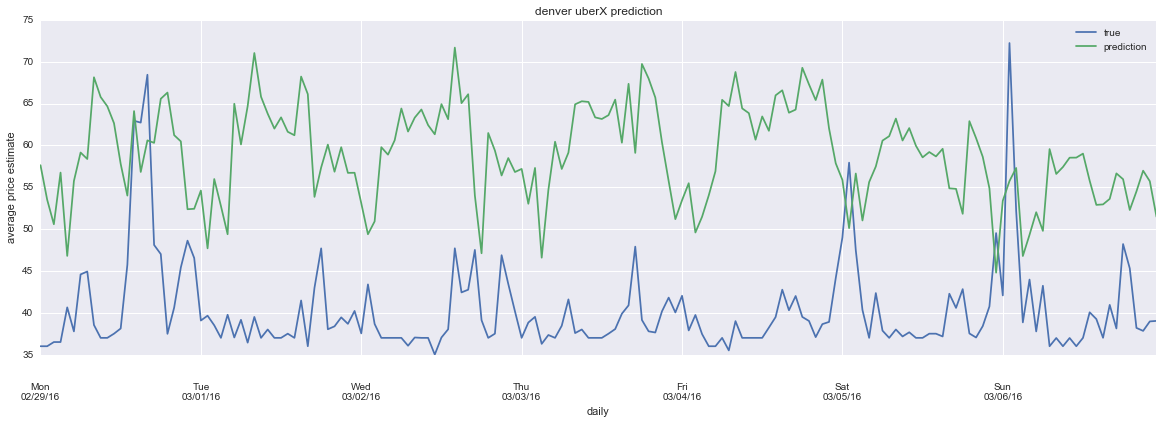

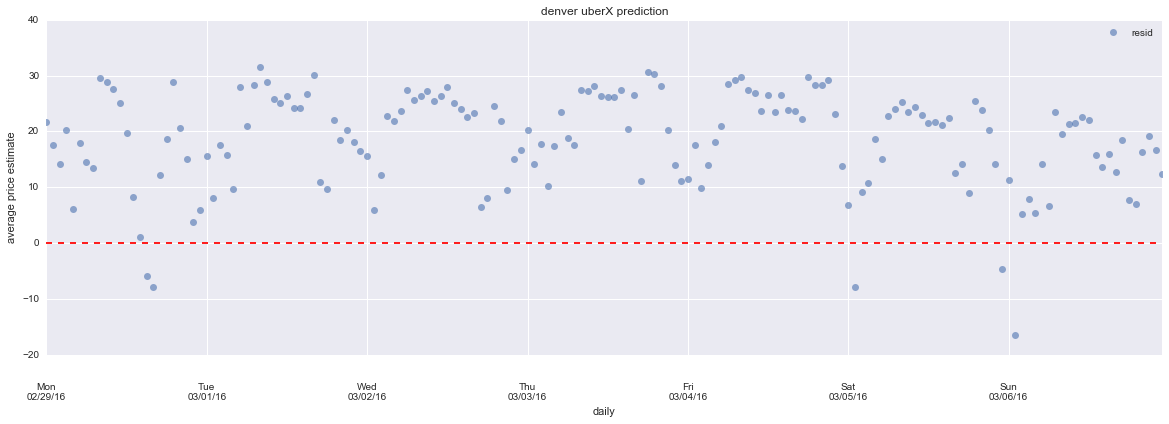

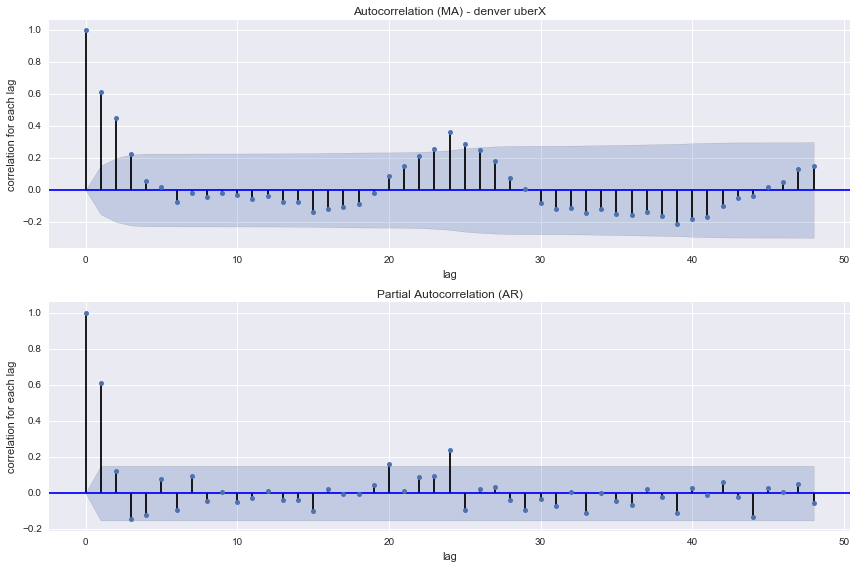

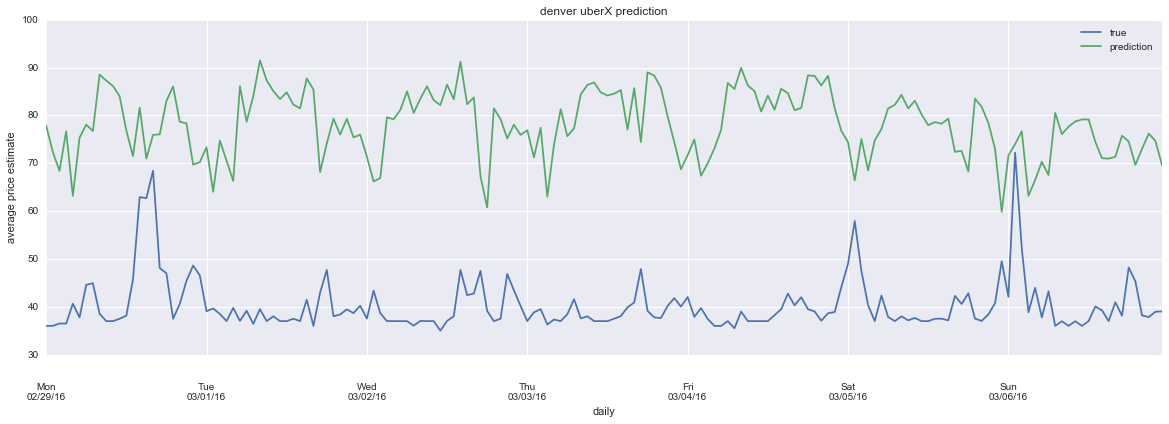

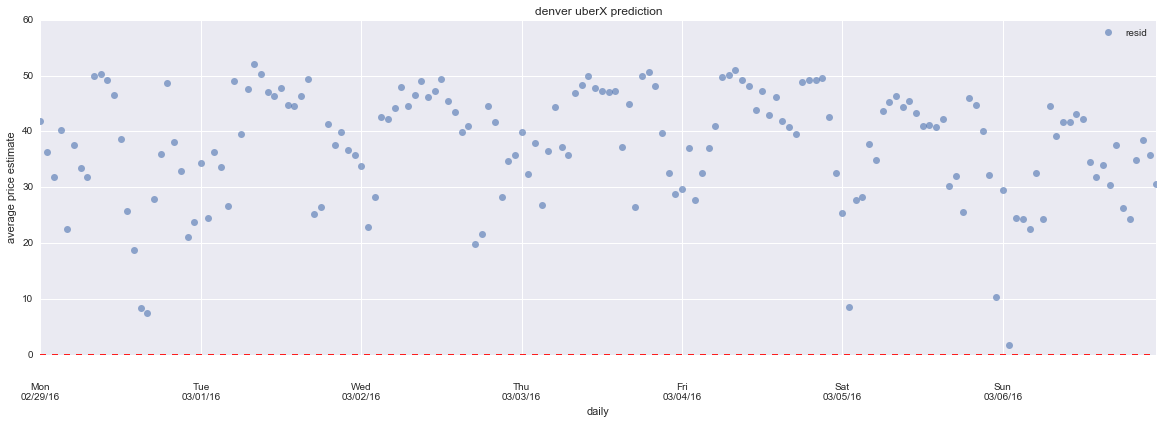

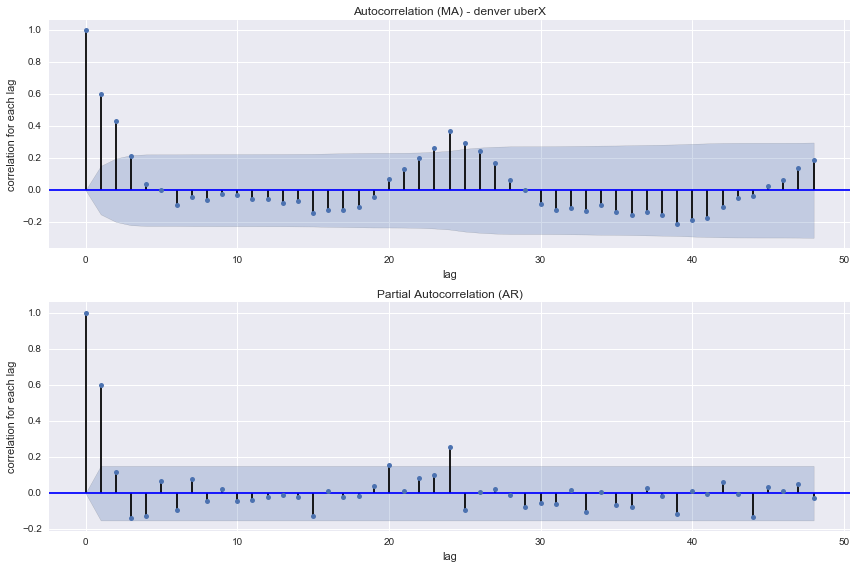

In [90]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

X_test = test_set[test_set.columns[1:]]
y_test = test_set['avg_price_est'].values

def regression_models(estimator, X, y, X_test, y_test):
    model = estimator.fit(X, y)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print "{} MSE: {}".format(estimator.__class__.__name__, mse)
    y_pred = pd.DataFrame(y_pred, index=test_set.index, columns=['y_pred'])
    testplot = pd.concat([test_set, y_pred], axis=1)
    testplot['resid'] = testplot['y_pred'] - testplot['avg_price_est'] 
    testsample = testplot.query("display_name_uberX == 1 and city_denver == 1")

    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot_date(testsample.index.to_pydatetime(), testsample['avg_price_est'].values, '-', label='true');
    ax.plot_date(testsample.index.to_pydatetime(), testsample['y_pred'].values, '-', label='prediction');
    ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
    ax.xaxis.grid(True, which="minor")
    ax.set_xlabel('daily')
    ax.set_ylabel('average price estimate');
    ax.set_title('denver uberX prediction');
    ax.legend(loc='upper right')

    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot_date(testsample.index.to_pydatetime(), testsample['resid'].values, 'o', label='resid', alpha=0.6);
    ax.xaxis.set_major_locator(WeekdayLocator(byweekday=range(7), interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('\n\n%a\n%D'))
    ax.xaxis.grid(True, which="minor")
    ax.axhline(0, color='r', ls='--')
    ax.set_xlabel('daily')
    ax.set_ylabel('average price estimate');
    ax.set_title('denver uberX prediction');
    ax.legend(loc='upper right');

    plot_acf_pacf(testsample['resid'], lags=48, label='denver uberX')

for estimator in [LinearRegression(), Ridge(), Lasso(), ElasticNet()]:
    regression_models(estimator, X, y, X_test, y_test)

In [77]:
linreg.__class__.__name__

'LinearRegression'

In [84]:
mean_squared_error?